In [1]:
import numpy as np
from scipy.odr import ODR, Model, RealData
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt


In [2]:
raw_T10 = np.array([
[16.45, 16.53, 16.52, 16.50, 16.47], 
[14.69, 14.69, 14.76, 14.73, 14.71], 
[13.10, 13.16, 13.18, 13.11, 13.07], 
[11.08, 11.07, 11.09, 11.12, 11.01], 
[8.61, 8.50, 8.55, 8.61, 8.54]])

T10_mean = np.mean(raw_T10, axis = 1)
T10_ustat = np.std(raw_T10, axis = 1, ddof =1)/np.sqrt(raw_T10.shape[1])

print(T10_mean)
print(T10_ustat)

T10_u = np.sqrt( T10_ustat**2 + (0.01*np.ones(raw_T10.shape[1]))**2 )
                 
print(T10_u)

T_mean = T10_mean/10
sT = T10_u/10

print(T_mean)
print(sT)

[16.494 14.716 13.124 11.074  8.562]
[0.0150333  0.0132665  0.02014944 0.01805547 0.02130728]
[0.01805547 0.01661325 0.02249444 0.02063977 0.0235372 ]
[1.6494 1.4716 1.3124 1.1074 0.8562]
[0.00180555 0.00166132 0.00224944 0.00206398 0.00235372]


recall for $f = x^n$, $u_f  = |n x^{n-1}| u_x$

In [3]:
Tsquare_mean = T_mean**2 
print(Tsquare_mean)
sT_square = 2*T_mean*sT
print(sT_square)

[2.72052036 2.16560656 1.72239376 1.22633476 0.73307844]
[0.00595614 0.00488961 0.00590434 0.0045713  0.00403051]


In [4]:


# Example data
l0 = np.array([65, 50.5, 40, 27.8, 15.2], dtype=float)/100
sl0 = np.array([0.029, 0.029, 0.029, 0.029, 0.029])/100  # uncertainties in l0




# Linear model
def f(B, x):
    return B[0] * x + B[1]  # slope * x + intercept

linear = Model(f)
data = RealData(l0, Tsquare_mean, sl0, sT_square)

odr = ODR(data, linear, beta0=[2., 0.])
out = odr.run()

out.pprint()

slope, intercept = out.beta
cov = out.cov_beta      # covariance matrix [[var_m, cov],[cov, var_b]]
var_m, var_b = cov[0,0], cov[1,1]
cov_mb = cov[0,1]

Beta: [4.02017042 0.1185701 ]
Beta Std Error: [0.03368695 0.01334448]
Beta Covariance: [[ 1.69019815e-04 -6.01732779e-05]
 [-6.01732779e-05  2.65227068e-05]]
Residual Variance: 6.714068078115594
Inverse Condition #: 0.09757575046538261
Reason(s) for Halting:
  Sum of squares convergence


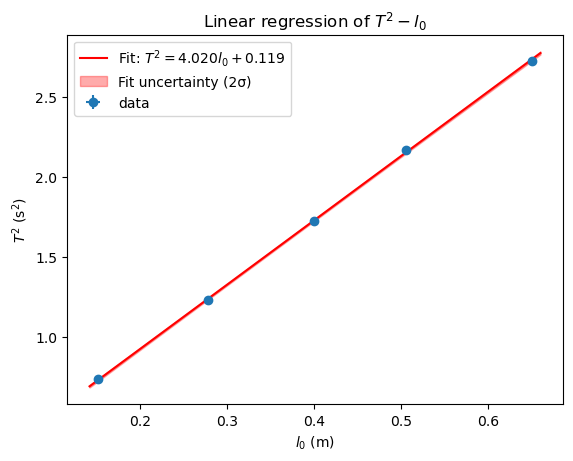

In [5]:
# Prediction line
l0_fit = np.linspace(min(l0)-0.01, max(l0)+0.01)
Tsquare_fit = slope * l0_fit + intercept

# Uncertainty on prediction
sigma_Tsquare = np.sqrt( var_m*l0_fit**2 +
                         var_b + 
                         2*cov_mb*l0_fit +
                         (slope**2)*(np.mean(sl0)**2) )

plt.errorbar(l0, Tsquare_mean, xerr=sl0, yerr=sT_square, fmt='o', label="data")

plt.plot(l0_fit , Tsquare_fit, 'r-', label=f"Fit: $T^2={slope:.3f}l_0+{intercept:.3f}$")
plt.fill_between(l0_fit , Tsquare_fit - 2*sigma_Tsquare, Tsquare_fit + 2*sigma_Tsquare, color='r', alpha=0.33,
                 label="Fit uncertainty (2σ)")


plt.xlabel(r"$l_0$ (m)")
plt.ylabel(r"$T^2$ (s$^2$)")
plt.legend()
plt.title(r"Linear regression of $T^2 - l_0$")
plt.show()

In [6]:
import pandas as pd

df = pd.read_csv('pendulumData.csv')

In [7]:
print(df)

               label  g (m/s2) stat uncert     sys uncert total uncert
0    20.Sep.X.B01.01     9.830      0.0075  "+0.35,-0.44"          NaN
1    20.Sep.X.B01.02     9.060        0.14           0.23          NaN
2    20.Sep.X.B01.03     9.790        0.02           0.02          NaN
3    20.Sep.X.B01.04     9.882       0.016           0.13          NaN
4    20.Sep.X.B01.05   978.000          17              8          NaN
..               ...       ...         ...            ...          ...
477   25.Feb.B.B02.5     9.850         NaN            NaN         0.03
478   25.Feb.B.B02.6     9.600         0.2            0.1          NaN
479   25.Feb.B.B02.7     9.778         NaN            NaN        0.017
480   25.Feb.B.B02.8     9.890         NaN            NaN          0.2
481   25.Feb.B.B02.9     9.700        0.18          0.028          NaN

[482 rows x 5 columns]


Text(0.5, 0, '$g$(m/s$^2$)')

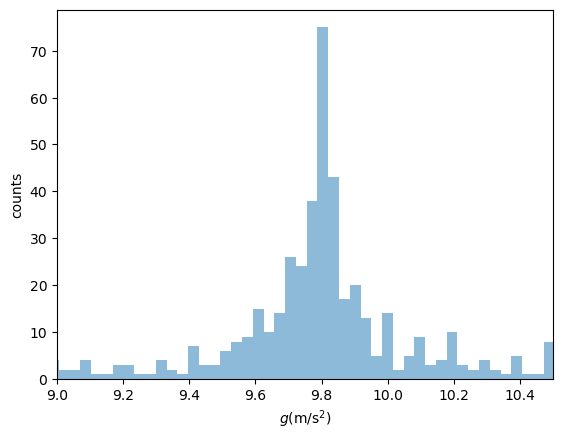

In [8]:
plt.hist(df['g (m/s2)'], alpha =0.5, bins = 30000)
plt.xlim(9.0, 10.5)
plt.ylabel('counts')
plt.xlabel(r'$g$(m/s$^2$)')

In [9]:
np.mean(df['g (m/s2)'])

np.float64(11.842510332840247)

In [10]:
np.std(df['g (m/s2)'])

np.float64(44.059951957262534)

In [11]:
len(df['g (m/s2)'])

482

In [12]:
#find weird values

print(np.where(df['g (m/s2)']>=15))
print(np.where(df['g (m/s2)']<=5))

(array([  4, 226]),)
(array([466]),)


In [13]:
df['g (m/s2)'][4]

#clearly this one forgot to change units lol

np.float64(978.0)

In [14]:
df_trimmed = df[(df['g (m/s2)'] >= 8) & (df['g (m/s2)'] <= 11)]

Text(0.5, 0, '$g$(m/s$^2$)')

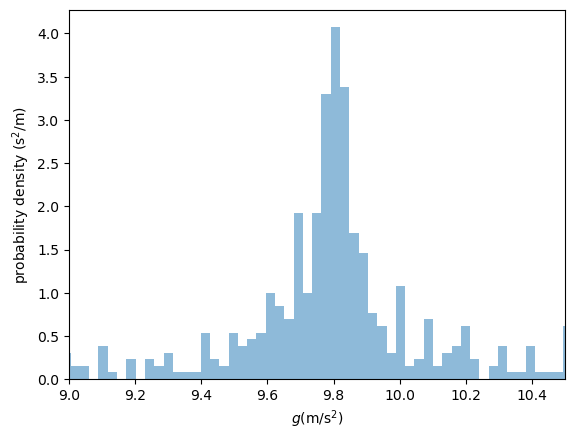

In [22]:
plt.hist(df_trimmed['g (m/s2)'], density = True, alpha =0.5, bins = 100)
plt.xlim(9.0, 10.5)
plt.ylabel(r'probability density (s$^2$/m)')
plt.xlabel(r'$g$(m/s$^2$)')

In [71]:
counts, bin_edges = np.histogram(df_trimmed['g (m/s2)'], bins=50, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2 

In [72]:
def gaussian(x, mu, sigma):
    return np.exp(-(x - mu)**2 / (2* sigma**2))/np.sqrt(2*np.pi*sigma**2)

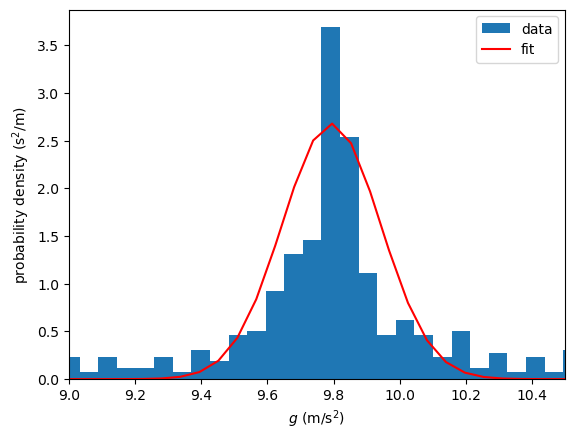

chi² = 31407807.38, reduced chi² = 654329.32
[9.79344007 0.14894361]
[[ 1.49190289e-04 -7.32164101e-11]
 [-7.32164101e-11  9.94601957e-05]]


<Figure size 640x480 with 0 Axes>

In [73]:


popt, pcov = curve_fit(gaussian, bin_centers, counts, p0=[9.8, 0.05]) 



# --- Step 5: Plot result ---

plt.hist(df_trimmed['g (m/s2)'], bins=50, density=True, label = 'data')
x_fit = np.linspace(bin_edges[0], bin_edges[-1], 50)
plt.plot(x_fit, gaussian(x_fit, *popt), 'r-', label="fit")
plt.legend()
plt.xlim(9,10.5)
plt.xlabel(r'$g$ (m/s$^2$)')
plt.ylabel(r'probability density (s$^2$/m)')
#plt.title('histogram of $g$ values')
plt.show()

# --- Compute chi² ---
expected = gaussian(bin_centers, *popt)
observed = counts
# avoid division by zero by adding small epsilon
chi2 = np.sum((observed - expected) ** 2 / (expected + 1e-9))

# degrees of freedom = number of data points - number of fit parameters
ndof = len(observed) - len(popt)
chi2_red = chi2 / ndof

print(f"chi² = {chi2:.2f}, reduced chi² = {chi2_red:.2f}")

print(popt)
print(pcov)

plt.savefig('g_hist.png')

In [74]:
np.std(df_trimmed['g (m/s2)'])

np.float64(0.35988967606111155)

In [75]:
x_range = np.linspace(9.79438658 - 2*0.13901386, 9.79438658 + 2*0.13901386)

def integrand(x):
    return gaussian(x, *popt)

from scipy.integrate import quad 
integral, err = quad(integrand, 9.79438658 - 2*0.13901386, 9.79438658 + 2*0.13901386)

In [76]:
print(integral)

0.9380462543563342


In [68]:
print(
    np.intersect1d( np.where(df['g (m/s2)']<=9.79438658 + 2*0.13901386), 
                np.where(df['g (m/s2)']>=9.79438658 - 2*0.13901386)  ).shape
)

(336,)


In [69]:
print(336/df_trimmed.shape[0])

0.7257019438444925
